# 🗺️ Network Analysis with Python

**Universidad Nacional de Colombia**  
*Facultad de Ciencias Agrarias*  

**Lecturer:** Liliana Castillo Villamor  

---

> *This notebook was adapted from:*  
> <https://autogis-site.readthedocs.io/en/2019/notebooks/L6/network-analysis.html>





## 0. Introduction to Network Analysis

**Networks** – or **graphs**, to use the mathematical term – provide a powerful framework for modelling and analysing relationships between entities.  In its simplest form, a graph consists of:

* **Nodes** (vertices): the objects or entities that take part in the relationships (people, cities, genes, etc.).
* **Edges** (links): the connections that join pairs of nodes and describe a specific relationship (friendship, road, biological interaction, and so on).

Both nodes and edges can carry **metadata** as key–value pairs.  For example, in a social network the nodes “Hugo” and “Eric” might each have an attribute `{ "age": 25 }`, while the edge between them could store `{ "first_met": "2016-05-21" }`.

### Why model data as a network?

Representing data as a graph allows  to tackle questions that are difficult to answer with conventional tables, such as:

* Who are the key influencers within an online community?  
* What is the optimal route between two cities in a transport network?  
* Are there densely connected clusters or communities in the network?


Finding a shortest path using a specific street network is a common GIS problem that has many practical applications. For example, navigation, one of those  applications for which **routing** algorithms are used to find the optimal route between two or more points.

By examining the **structure** of a graph we can compute node‐level metrics (e.g. centrality), identify critical bridges, or detect natural community groupings.

In Python, the **NetworkX** library (imported as `nx`) provides an intuitive API for creating, manipulating and visualising graphs in memory.



[1, 2, 3]
[(1, 2)]


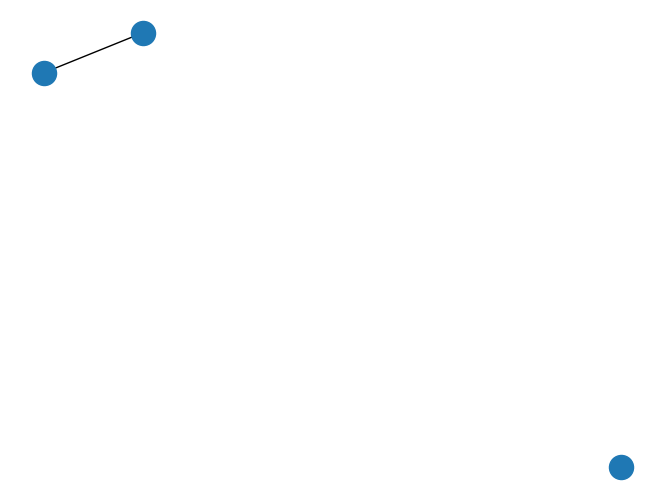

In [15]:
import networkx as nx

# Create an empty, undirected graph
G = nx.Graph()

# Add nodes and an edge
G.add_nodes_from([1, 2, 3])
G.add_edge(1, 2)

# Inspect nodes and edges
print(G.nodes())    # → [1, 2, 3]
print(G.edges())    # → [(1, 2)]

# Attach metadata
G.nodes[1]["label"] = "blue"

# Basic visualisation (requires matplotlib.pyplot as plt)
nx.draw(G)


The [NetworkX](https://networkx.github.io/documentation/) package provides various
tools to analyse networks, and implements several different routing algorithms,
such as the
[Dijkstra’s](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.generic.shortest_path.html)
or the
[A\*](https://networkx.org/documentation/stable/reference/algorithms/shortest_paths.html#module-networkx.algorithms.shortest_paths.astar)
algorithms. Both are commonly used to find shortest paths along transport networks.

To be able to conduct network analysis, it is, of course, necessary to have a
network that is used for the analyses. The
[OSMnx](https://osmnx.readthedocs.io/) package enables us to retrieve routable
networks from OpenStreetMap for various transport modes (walking, cycling and
driving). OSMnx also wraps some of NetworkX’s functionality in a convenient way
for using it on OpenStreetMap data.

In the following section, we will use OSMnx to find the shortest path between
two points based on cyclable roads. With only the tiniest modifications, we can
then repeat the analysis for the walkable street network.




## 1. Obtain a routable network

To download OpenStreetMap data that represents the street network, we can use
it’s
[`graph_from_place()`](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.graph.graph_from_place)
function. As parameters, it expects a place name and, optionally, a network
type.

In [123]:
!pip install osmnx==1.3.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 2.2 MB/s eta 0:00:0000:01
  Attempting uninstall: osmnx
    Found existing installation: osmnx 2.0.4
    Uninstalling osmnx-2.0.4:
      Successfully uninstalled osmnx-2.0.4


In [130]:
import osmnx

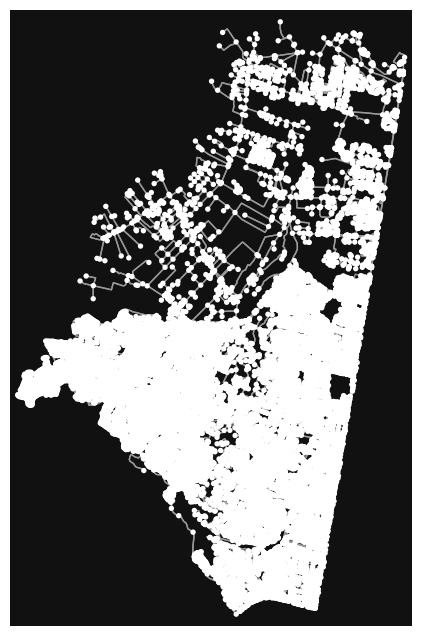

In [23]:
PLACE_NAME = "Suba, Bogotá, Colombia"
graph = osmnx.graph_from_place(
    PLACE_NAME,
    network_type="all"
)
figure, ax = osmnx.plot_graph(graph)

> **Pro tip!**  
> Sometimes the shortest path might go slightly outside the defined area of interest. To account for this, we can fetch the network for a bit larger area than the district of Kamppi, in case the shortest path is not completely inside its boundaries.

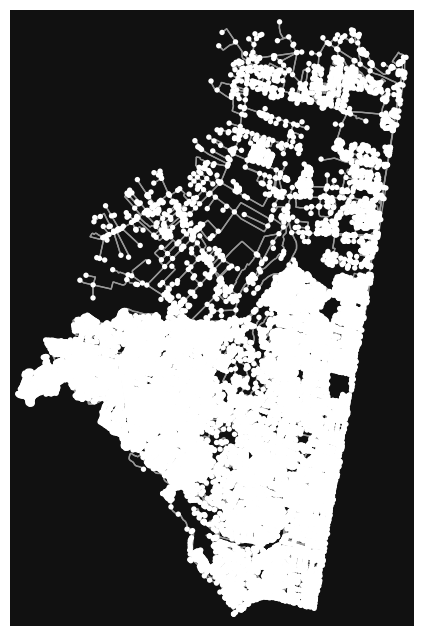

In [160]:
# Get the area of interest polygon
place_polygon = osmnx.geocode_to_gdf(PLACE_NAME)

# Re-project the polygon to a local projected CRS (so that the CRS unit is meters)
place_polygon = place_polygon.to_crs("EPSG:3067")

# Buffer by 200 meters
place_polygon["geometry"] = place_polygon.buffer(200)

# Re-project the polygon back to WGS84 (required by OSMnx)
place_polygon = place_polygon.to_crs("EPSG:4326")

# Retrieve the network graph
graph = osmnx.graph_from_polygon(
    place_polygon.at[0, "geometry"],
    network_type="all"
)

fig, ax = osmnx.plot_graph(graph)

### 1.1. Data overview

Now that we obtained a complete network graph for the travel mode we specified
(cycling), we can take a closer look at which attributes are assigned to the
nodes and edges of the network. It is probably easiest to first convert the
network into a geo-data frame on which we can then use the tools we learnt in
earlier lessons.

To convert a graph into a geo-data frame, we can use `osmnx.graph_to_gdfs()`
(see [previous section](retrieve-data-from-openstreetmap)). Here, we can make
use of the function’s parameters `nodes` and `edges` to select whether we want
only nodes, only edges, or both (the default):

In [161]:
# Retrieve only edges from the graph
edges = osmnx.graph_to_gdfs(graph, nodes=False, edges=True)
edges.head()

osmid  highway  oneway reversed      length  \
u         v           key                                                     
255476400 4913735031  0     645873850  footway   False    False    8.146538   
          381991485   0    1195009265  primary    True    False   11.921676   
          11774394549 0     645873850  footway   False     True   12.706621   
259665451 5718775594  0     809284675    trunk    True    False  745.334231   
          273536445   0    1153629523    trunk    True    False  110.133567   

                          lanes                name  \
u         v           key                             
255476400 4913735031  0     NaN                 NaN   
          381991485   0       3      Transversal 60   
          11774394549 0     NaN                 NaN   
259665451 5718775594  0       3  Avenida Carrera 45   
          273536445   0       2  Avenida Carrera 45   

                                                                    geometry  \
u         v           key                                                      
255476400 4913735031  0    LINESTRING (-74.07226 4.71122, -74.07219 4.71124)   
          381991485   0    LINESTRING (-74.07226 4.71122, -74.07224 4.71112)   
          11774394549 0    LINESTRING (-74.07226 4.71122, -74.07231 4.711...   
259665451 5718775594  0    LINESTRING (-74.04663 4.75285, -74.04657 4.752...   
          273536445   0    LINESTRING (-74.04663 4.75285, -74.04663 4.752...   

                          maxspeed  ref service access bridge junction width  \
u         v           key                                                      
255476400 4913735031  0        NaN  NaN     NaN    NaN    NaN      NaN   NaN   
          381991485   0        NaN  NaN     NaN    NaN    NaN      NaN   NaN   
          11774394549 0        NaN  NaN     NaN    NaN    NaN      NaN   NaN   
259665451 5718775594  0         50  NaN     NaN    NaN    NaN      NaN   NaN   
          273536445   0         60  NaN     NaN    NaN    NaN      NaN   NaN   

                          area tunnel  
u         v           key              
255476400 4913735031  0    NaN    NaN  
          381991485   0    NaN    NaN  
          11774394549 0    NaN    NaN  
259665451 5718775594  0    NaN    NaN  
          273536445   0    NaN    NaN

The resulting geo-data frame comprises of a long list of columns. Most of them
relate to [OpenStreetMap tags](https://wiki.openstreetmap.org/wiki/Tags), and
their names are rather self-explanatory. the columns `u` and `v` describe the
topological relationship within the network: they denote the start and end node
of each edge.

| Column                                                                 | Description                         | Data type         |
|------------------------------------------------------------------------|-------------------------------------|-------------------|
| [bridge](http://wiki.openstreetmap.org/wiki/Key:bridge)                | Bridge feature                      | boolean           |
| geometry                                                              | Geometry of the feature             | Shapely.geometry  |
| [highway](http://wiki.openstreetmap.org/wiki/Key:highway)              | Tag for roads (road type)           | str / list        |
| [lanes](http://wiki.openstreetmap.org/wiki/Key:lanes)                  | Number of lanes                     | int (or nan)      |
| [length](http://wiki.openstreetmap.org/wiki/Key:length)                | Length of feature (meters)          | float             |
| [maxspeed](http://wiki.openstreetmap.org/wiki/Key:maxspeed)            | Maximum legal speed limit           | int / list        |
| [name](http://wiki.openstreetmap.org/wiki/Key:name)                    | Name of the (street) element        | str (or nan)      |
| [oneway](http://wiki.openstreetmap.org/wiki/Key:oneway)                | One way road                        | boolean           |
| [osmid](http://wiki.openstreetmap.org/wiki/Node)                       | Unique ids for the element          | list              |
| [u](http://ow.ly/bV8n30h7Ufm)                                         | The start node of edge              | int               |
| [v](http://ow.ly/bV8n30h7Ufm)                                         | The end node of edge                | int               |



What types of streets does our network comprise of?

In [162]:
edges["highway"].value_counts()

highway
residential                         20584
footway                             19040
service                             14744
tertiary                             3934
cycleway                             2376
secondary                            1483
primary                              1048
[footway, residential]                566
trunk                                 446
path                                  344
[footway, service]                    178
unclassified                          156
primary_link                          149
corridor                              124
trunk_link                            117
[footway, corridor]                    94
pedestrian                             93
steps                                  84
[footway, steps]                       80
[service, residential]                 70
track                                  48
[cycleway, footway]                    22
[steps, residential]                   18
secondary_link            

### 1.2. Transform to projected reference system

The network data’s cartographic reference system (CRS) is WGS84 (EPSG:4326), a
geographic reference system. That means, distances are recorded and expressed
in degrees, areas in square-degrees. This is not convenient for network
analyses, such as finding a shortest path.

Again, OSMnx’s *graph* objects do not offer a method to transform their
geodata, but OSMnx comes with a separate function:
[`osmnx.project_graph()`](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.projection.project_graph)
accepts an input graph and a CRS as parameters, and returns a new, transformed,
graph. If `crs` is omitted, the transformation defaults to the locally most
appropriate UTM zone.

In [163]:
# Transform the graph to UTM
graph = osmnx.project_graph(graph) 

# Extract reprojected nodes and edges
nodes, edges = osmnx.graph_to_gdfs(graph)

nodes.crs

<Projected CRS: EPSG:32618>
Name: WGS 84 / UTM zone 18N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 78°W and 72°W, northern hemisphere between equator and 84°N, onshore and offshore. Bahamas. Canada - Nunavut; Ontario; Quebec. Colombia. Cuba. Ecuador. Greenland. Haiti. Jamaica. Panama. Turks and Caicos Islands. United States (USA). Venezuela.
- bounds: (-78.0, 0.0, -72.0, 84.0)
Coordinate Operation:
- name: UTM zone 18N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

---


## 2. Analysing network properties

Now that we have prepared a routable network graph, we can turn to the more
analytical features of OSMnx, and extract information about the network.
To compute basic network characteristics, use
[`osmnx.basic_stats()`](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.stats.basic_stats):

In [164]:
# Calculate network statistics
osmnx.basic_stats(graph)

{'n': 25248,
 'm': 65868,
 'k_avg': 5.217680608365019,
 'edge_length_total': 3467541.6597680007,
 'edge_length_avg': 52.643797591668196,
 'streets_per_node_avg': 2.8509980988593155,
 'streets_per_node_counts': {0: 0,
  1: 4657,
  2: 39,
  3: 15044,
  4: 5434,
  5: 65,
  6: 9},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.1844502534854246,
  2: 0.0015446768060836502,
  3: 0.5958491761723701,
  4: 0.21522496831432192,
  5: 0.0025744613434727504,
  6: 0.0003564638783269962},
 'intersection_count': 20591,
 'street_length_total': 1915249.8671735208,
 'street_segment_count': 35918,
 'street_length_avg': 53.32284278560947,
 'circuity_avg': 1.064269513303356,
 'self_loop_proportion': 0.0033131020658165823}

This does not yet yield all interesting characteristics of our network, as
OSMnx does not automatically take the area covered by the network into
consideration. We can do that manually, by, first, delineating the [complex
hull](https://en.wikipedia.org/wiki/Convex_hull) of the network (of an ’unary’
union of all its features), and then, second, computing the area of this hull.

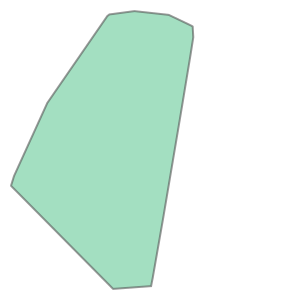

In [32]:
convex_hull = edges.geometry.union_all().convex_hull
convex_hull

In [33]:
stats = osmnx.basic_stats(graph, area=convex_hull.area)
stats

{'n': 14910,
 'm': 34247,
 'k_avg': 4.59382964453387,
 'edge_length_total': 2251419.357800152,
 'edge_length_avg': 65.74063006395166,
 'streets_per_node_avg': 2.617773306505701,
 'streets_per_node_counts': {0: 0,
  1: 3975,
  2: 36,
  3: 8641,
  4: 2232,
  5: 23,
  6: 3},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.2665995975855131,
  2: 0.002414486921529175,
  3: 0.5795439302481556,
  4: 0.14969818913480884,
  5: 0.0015425888665325286,
  6: 0.00020120724346076458},
 'intersection_count': 10935,
 'street_length_total': 1301801.1987624117,
 'street_segment_count': 19470,
 'street_length_avg': 66.86190029596362,
 'circuity_avg': 1.0578768503201337,
 'self_loop_proportion': 0.003389830508474576,
 'node_density_km': 134.69312761140338,
 'intersection_density_km': 98.78399399266908,
 'edge_density_km': 20338.74680529576,
 'street_density_km': 11760.139167644764}

### 2.1. 🚀 **Now it’s your turn! — Exploring street attributes**

1. **Calculate** the total length of streets classified as `residential`, `primary`, and `secondary`.  
2. **Compare** the mean length for each class.  
3. **Visualise** the five longest street classes in a bar chart.

> 💡 *Hint:* `edges.groupby("highway")["length"].sum()` followed by `.sort_values()` will help.



In [37]:
edges_1= edges.copy()

edges_1=edges_1.explode("highway")

edges_1["highway"]= edges_1["highway"].fillna("unknow").astype(str)

In [62]:
Long_Clase_Km= (
    edges_1.groupby("highway")["length"]
    .sum()
    .sort_values(ascending=False)
    / 1000
)

Long_Clase_Km.loc[["residential", "primary", "secondary"]]

highway
residential    1087.630340
primary          73.541562
secondary        66.701155
Name: length, dtype: float64

In [43]:
Media_Clase= (
    edges_1.groupby("highway")["length"]
    .mean()
    .sort_values(ascending=False)
)

display(Media_Clase)

highway
track             334.714849
unclassified      244.887553
trunk             129.743216
cycleway          124.750551
trunk_link         97.525246
primary            93.445441
path               88.331455
pedestrian         66.838375
residential        63.678591
tertiary           58.660208
secondary_link     57.679791
service            56.686781
primary_link       55.209188
secondary          53.834669
busway             42.253445
tertiary_link      15.871986
Name: length, dtype: float64

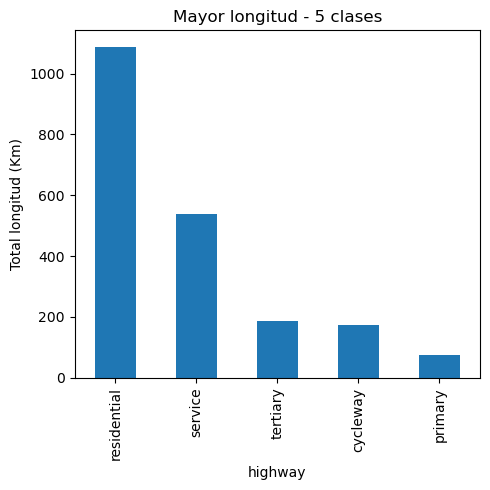

In [60]:
import matplotlib.pyplot as plt

Long_Clase_Km.head(5).plot(kind="bar", figsize=(5, 5))
plt.ylabel("Total longitud (Km)")
plt.title("Mayor longitud - 5 clases")
plt.tight_layout()
plt.show()

In [14]:
!pip install myst_nb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.6/84.6 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.3/55.3 kB 5.2 MB/s eta 0:00:00


In [102]:
import math
import myst_nb

myst_nb.glue("node_density_km", round(stats["node_density_km"], 1))
myst_nb.glue("edge_length_total", math.floor(stats["edge_length_total"] / 1000))

134.7

2251

As we can see, now we have a lot of information about our street network that
can be used to understand its structure. We can for example see that the average
node density in our network is {glue:}`node_density_km`&nbsp;nodes/km and that
the total edge length of our network is more than
{glue:}`edge_length_total`&nbsp;kilometers.


> **Note: Centrality measures**  
> In earlier years, this course also discussed [degree centrality](https://en.wikipedia.org/wiki/Centrality). Computing network centrality has changed in OSMnx: going in-depth would be beyond the scope of this course. Please see the [OSMnx notebook](https://github.com/gboeing/osmnx-examples/blob/main/notebooks/06-stats-indicators-centrality.ipynb) for an example.


---


## 3. Shortest path analysis

Let’s now calculate the shortest path between two points using
[`osmnx.shortest_path()`](https://osmnx.readthedocs.io/en/stable/osmnx.html?highlight=get_nearest_node#osmnx.distance.shortest_path).



### 3.1. Origin and destination points 

First we need to specify the source and target locations for our route. If you
are familiar with the Kamppi area, you can specify a custom placename as a
source location. Or, you can follow along and choose these points as the origin
and destination in the analysis:
- [`"Maria 01, Helsinki"`](https://nominatim.openstreetmap.org/ui/search.html?q=Maria+01):
  a startup hub in a former hospital area.
- [`"ruttopuisto"`](https://nominatim.openstreetmap.org/ui/search.html?q=ruttopuisto),
  a park. The park’s official name is ’Vanha kirkkopuisto’, but Nominatim
  is also able to geocode the nickname.

We could figure out the coordinates for these locations manually, and create
`shapely.geometry.Point`s based on the coordinates.  However, if we would have
more than just two points, that would quickly become a chore. Instead, we can
use OSMnx to geocode the locations.

Remember to transform the origin and destination points to the same reference
system as the network data.

In [108]:
origin = (
    osmnx.geocode_to_gdf("parque la gaitana, bogota")  # fetch geolocation
    .to_crs(edges.crs)  # transform to UTM
    .at[0, "geometry"]  # pick geometry of first row
    .centroid  # use the centre point
)

destination = (
    osmnx.geocode_to_gdf("cerro la conejera, bogota")
    .to_crs(edges.crs)
    .at[0, "geometry"]
    .centroid
)

We now have `shapely.geometry.Point`s representing the origin and destination
locations for our network analysis. In a next step, we need find these points on
the routable network before the final routing.



### 3.2. Nearest node

To route on the network, we first have to find a starting point and endpoint
that is part of the network. Use
`[osmnx.distance.nearest_nodes()`](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.distance.nearest_nodes)
to return the nearest node’s ID:

In [134]:
origin_node_id = osmnx.nearest_nodes(graph, origin.x, origin.y)
origin_node_id

7003340571

In [135]:
destination_node_id = osmnx.nearest_nodes(graph, destination.x, destination.y)
destination_node_id

9427357224

### 3.3. Routing

Now we are ready for routing and to find the shortest path between the
origin and target locations. We will use
[`osmnx.shortest_path()`](https://osmnx.readthedocs.io/en/stable/osmnx.html?highlight=get_nearest_node#osmnx.distance.shortest_path).

The function accepts three mandatory parameters: a graph, an origin node id, and
a destination node id, and two optional parameters: `weight` can be set to
consider a different *cost impedance* than the length of the route, and `cpus`
controls parallel computation of many routes.

In [165]:
# Find the shortest path between origin and destination
route = osmnx.shortest_path(graph, origin_node_id, destination_node_id)
route

[7003340571,
 7003340569,
 507912081,
 7003340558,
 10116648728,
 5113954454,
 1068231833,
 10116648759,
 5113954458,
 5113954474,
 507882224,
 1068231471,
 507882151,
 507882174,
 5731577442,
 10096015836,
 10096015794,
 10096015793,
 310613554,
 10096015818,
 5113932260,
 1068231792,
 504452361,
 504452357,
 504452350,
 1068560119,
 1068559897,
 504452335,
 315996370,
 504446697,
 504446695,
 1068560123,
 5113932281,
 320196220,
 504458929,
 1068559945,
 1068560079,
 6084438302,
 1068559789,
 1068559825,
 320196147,
 504330927,
 496970918,
 504464971,
 1068560014,
 504464936,
 6463470690,
 1068559799,
 323331124,
 1068560070,
 1068559894,
 1068559913,
 9993725822,
 9406848821,
 9993725829,
 9993714614,
 9993714616,
 6981681462,
 5265095485,
 5265095496,
 5265095486,
 5265095484,
 5265095483,
 5265046915,
 5265046917,
 5265046918,
 871073047,
 4929490478,
 3967695004,
 5252195324,
 4111773348,
 871072958,
 4913270819,
 1833722136,
 373221573,
 5378334862,
 5378334872,
 1355704035,
 84

As a result we get a list of all the nodes that are along the shortest path. 

We could extract the locations of those nodes from the `nodes`
GeoDataFrame and create a LineString presentation of the points, but luckily,
OSMnx can do that for us and we can plot shortest path by using
`plot_graph_route()` function:

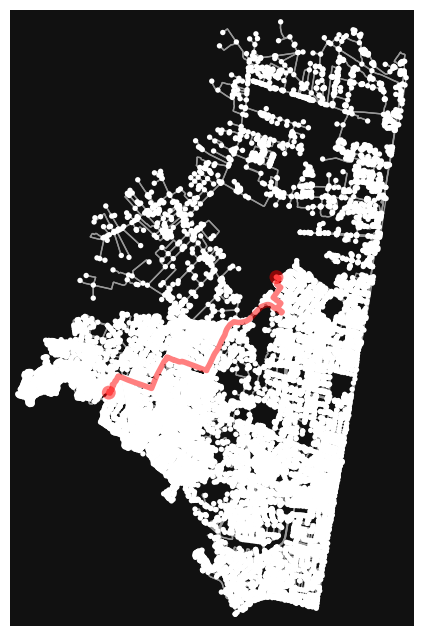

In [112]:
# Plot the shortest path
fig, ax = osmnx.plot_graph_route(graph, route)

### 3.4. 🚀 **Now it’s your turn! — Alternative routes**

1. **Calculate** a second route that avoids `motorway` and `trunk` streets.  
2. **Compare** its length with the original shortest route.  
3. **Discuss** in one sentence why constrained routes can be useful for certain users.

> 💡 You can filter `edges` before building a sub-graph or use `osmnx.utils_graph.get_route_edge_attributes`.


In [174]:
edges_to_keep = [
    (u, v, k) for u, v, k, d in graph.edges(keys=True, data=True)
    if not (
        d.get("highway") == "trunk" or
        d.get("highway") == "cycleway" or
        (isinstance(d.get("highway"), list) and (
            "trunk" in d["highway"] or "cycleway" in d["highway"])
        )
    )
]

In [175]:
graph_filtered = graph.edge_subgraph(edges_to_keep).copy()

In [176]:
import networkx as nx

route_alt = nx.shortest_path(graph_filtered, origin_node_id, destination_node_id, weight="length")


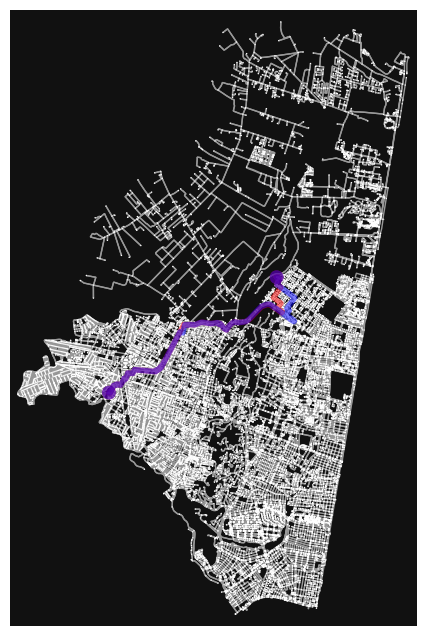

In [177]:
fig, ax = osmnx.plot_graph_routes(
    graph,
    routes=[route, route_alt],
    route_colors=["red", "blue"],
    route_linewidth=3,
    node_size=1
)


In [179]:
from osmnx.utils_graph import get_route_edge_attributes

# Longitud de la ruta original
length_original = sum(get_route_edge_attributes(graph, route, "length"))

# Longitud de la ruta alternativa
length_alt = sum(get_route_edge_attributes(graph, route_alt, "length"))

# Imprimir comparación
print(f"Longitud de la ruta original: {length_original:.2f} m")
print(f"Longitud de la ruta alternativa: {length_alt:.2f} m")
print(f"Diferencia: {length_alt - length_original:.2f} m")


Longitud de la ruta original: 7997.48 m
Longitud de la ruta alternativa: 8872.33 m
Diferencia: 874.85 m


In [180]:
from osmnx.utils_graph import get_route_edge_attributes

tipos = get_route_edge_attributes(graph, route_alt, "highway")
print(tipos)


['service', 'residential', 'residential', 'residential', 'residential', 'secondary', 'residential', 'residential', 'residential', 'residential', 'residential', 'residential', 'residential', 'footway', 'tertiary', 'footway', 'footway', 'secondary', 'residential', 'residential', 'residential', 'residential', 'residential', 'residential', 'residential', 'residential', 'footway', 'footway', 'residential', 'residential', 'residential', 'residential', 'residential', 'residential', 'residential', 'residential', 'residential', 'residential', 'residential', 'residential', 'residential', 'residential', 'residential', 'residential', 'residential', 'residential', 'residential', 'residential', 'residential', 'residential', 'residential', 'service', 'service', 'footway', 'footway', 'footway', 'footway', 'footway', 'footway', 'footway', 'footway', 'footway', 'footway', 'footway', 'footway', 'primary', 'primary', 'primary', 'primary', 'primary', 'primary', 'primary', 'primary', 'primary', 'primary', '

Nice! Now we have the shortest path between our origin and target locations.
Being able to analyze shortest paths between locations can be valuable
information for many applications.  Here, we only analyzed the shortest paths
based on distance but quite often it is more useful to find the optimal routes
between locations based on the travelled time. Here, for example we could
calculate the time that it takes to cross each road segment by dividing the
length of the road segment with the speed limit and calculate the optimal
routes by taking into account the speed limits as well that might alter the
result especially on longer trips than here.



## 4. Saving shortest paths to disk

Quite often you need to save the route into a file for further analysis and
visualization purposes, or at least have it as a GeoDataFrame object in Python.
Hence, let's continue still a bit and see how we can turn the route into a
linestring and save the shortest path geometry and related attributes into a
geopackage file.

First we need to get the nodes that belong to the shortest path:

In [181]:
# Get the nodes along the shortest path
route_nodes = nodes.loc[route]
route_nodes

,y,x,highway,street_count,geometry
osmid,,,,,
7003340571,524053.574881,598812.281433,NaN,3,POINT (598812.281 524053.575)
7003340569,524039.521372,598844.762958,NaN,3,POINT (598844.763 524039.521)
507912081,524136.112815,598890.034318,NaN,3,POINT (598890.034 524136.113)
7003340558,524163.510192,598900.812815,NaN,3,POINT (598900.813 524163.51)
10116648728,524240.647538,598931.114011,crossing,4,POINT (598931.114 524240.648)
5113954454,524247.051679,598933.623426,NaN,3,POINT (598933.623 524247.052)
1068231833,524237.475708,598940.467815,NaN,3,POINT (598940.468 524237.476)
10116648759,524239.458311,598943.371108,crossing,4,POINT (598943.371 524239.458)
5113954458,524260.524689,598974.088259,NaN,3,POINT (598974.088 524260.525)


As we can see, now we have all the nodes that were part of the shortest path as a GeoDataFrame.

Now we can create a LineString out of the Point geometries of the nodes:

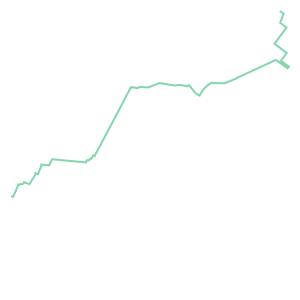

In [182]:
import shapely.geometry

# Create a geometry for the shortest path
route_line = shapely.geometry.LineString(
    list(route_nodes.geometry.values)
)
route_line

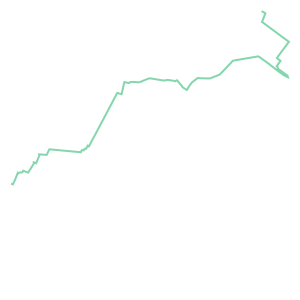

In [183]:
route_alt_nodes = nodes.loc[route_alt]

route_alt_line = shapely.geometry.LineString(
    list(route_alt_nodes.geometry.values)
)
route_alt_line

Now we have the route as a LineString geometry. 

Let's make a GeoDataFrame out of it having some useful information about our
route such as a list of the osmids that are part of the route and the length
of the route.

In [184]:
import geopandas

route_geom = geopandas.GeoDataFrame(
    {
        "geometry": [route_line],
        "osm_nodes": [route],
    },
    crs=edges.crs
)

# Calculate the route length
route_geom["length_m"] = route_geom.length

route_geom.head()

,geometry,osm_nodes,length_m
0,"LINESTRING (598812.281 524053.575, 598844.763 ...","[7003340571, 7003340569, 507912081, 7003340558...",7759.631521


Now we have a GeoDataFrame that we can save to disk. Let's still confirm that
everything is ok by plotting our route on top of our street network and some
buildings, and plot also the origin and target points on top of our map.

Download buildings:

In [185]:
buildings = osmnx.features_from_place(
    PLACE_NAME,
    {
        "building" : True
    }
).to_crs(edges.crs)

Let's now plot the route and the street network elements to verify that
everything is as it should:

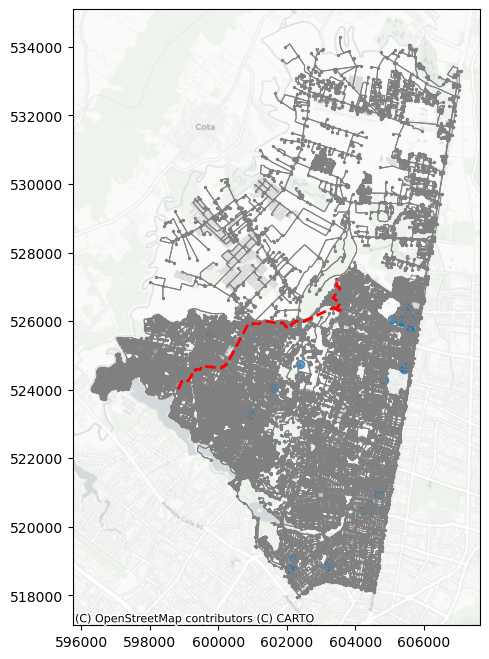

In [186]:
import contextily
import matplotlib.pyplot

fig, ax = matplotlib.pyplot.subplots(figsize=(12,8))

# Plot edges and nodes
edges.plot(ax=ax, linewidth=0.75, color='gray')
nodes.plot(ax=ax, markersize=2, color='gray')

# Add buildings
ax = buildings.plot(ax=ax, facecolor='lightgray', alpha=0.7)

# Add the route
ax = route_geom.plot(ax=ax, linewidth=2, linestyle='--', color='red')

# Add basemap
contextily.add_basemap(ax, crs=buildings.crs, source=contextily.providers.CartoDB.Positron)

Great everything seems to be in order! As you can see, now we have a full
control of all the elements of our map and we can use all the aesthetic
properties that matplotlib provides to modify how our map will look like. Now
we are almost ready to save our data into disk.



## Prepare data for saving to file

The data contain certain data types (such as `list`) that should be converted
into character strings prior to saving the data to file (an alternative would be
to drop invalid columns).

In [187]:
edges.head()

osmid  highway  oneway reversed     length  \
u          v           key                                                    
255476400  4913735031  0     645873850  footway   False    False   8.146538   
           381991485   0    1195009265  primary    True    False  11.921676   
           11774394549 0     645873850  footway   False     True  12.706621   
4913735031 4069368783  0     584488049  service    True    False  12.431178   
           255476400   0     645873850  footway   False     True   8.146538   

                           lanes            name  \
u          v           key                         
255476400  4913735031  0     NaN             NaN   
           381991485   0       3  Transversal 60   
           11774394549 0     NaN             NaN   
4913735031 4069368783  0     NaN    TransMilenio   
           255476400   0     NaN             NaN   

                                                                     geometry  \
u          v           key                                                      
255476400  4913735031  0    LINESTRING (602891.74 520811.6, 602899.679 520...   
           381991485   0    LINESTRING (602891.74 520811.6, 602894.273 520...   
           11774394549 0    LINESTRING (602891.74 520811.6, 602886.484 520...   
4913735031 4069368783  0    LINESTRING (602899.679 520813.446, 602902.257 ...   
           255476400   0    LINESTRING (602899.679 520813.446, 602891.74 5...   

                           access maxspeed  ref service bridge junction width  \
u          v           key                                                      
255476400  4913735031  0      NaN      NaN  NaN     NaN    NaN      NaN   NaN   
           381991485   0      NaN      NaN  NaN     NaN    NaN      NaN   NaN   
           11774394549 0      NaN      NaN  NaN     NaN    NaN      NaN   NaN   
4913735031 4069368783  0       no      NaN  NaN     NaN    NaN      NaN   NaN   
           255476400   0      NaN      NaN  NaN     NaN    NaN      NaN   NaN   

                           area tunnel  
u          v           key              
255476400  4913735031  0    NaN    NaN  
           381991485   0    NaN    NaN  
           11774394549 0    NaN    NaN  
4913735031 4069368783  0    NaN    NaN  
           255476400   0    NaN    NaN

In [188]:
# Columns with invalid values
problematic_columns = [
    "osmid",
    "lanes",
    "name",
    "highway",
    "width",
    "maxspeed",
    "reversed",
    "junction",
    "bridge",
    "tunnel",
    "access",
    "service",
    
]

#  convert selected columns to string format
edges[problematic_columns] = edges[problematic_columns].astype(str)

In [189]:
route_geom["osm_nodes"] = route_geom["osm_nodes"].astype(str)

Now we can see that most of the attributes are of type `object` that quite
often (such as ours here) refers to a string type of data.

## Save the data:

In [190]:
import pathlib
NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_DIRECTORY = NOTEBOOK_PATH / "data"
DATA_DIRECTORY.mkdir(parents=True, exist_ok=True)

### 🚀 **Now it’s your turn! — Extending your analysis**

1. **Create** a 50 m buffer around the route and select buildings intersecting it.  
2. **Count** buildings both in total and by `building` tag within this corridor.  
3. **Export** the result to `buildings_along_route.geojson`.  

> 💡 Try `buildings[buildings.intersects(buffer)]` or a spatial overlay with GeoPandas.



In [193]:
buffer_50m = route_line.buffer(50)

In [194]:
buildings_near = buildings[buildings.intersects(buffer_50m)]

In [195]:
buildings_near["building"].value_counts()

building
yes                   2962
apartments             921
house                  720
semidetached_house     651
residential            646
greenhouse             325
commercial             290
school                 276
construction           114
roof                    84
retail                  49
terrace                 39
university              30
church                  15
guardhouse              14
garage                   8
office                   7
warehouse                7
kindergarten             6
hospital                 5
industrial               5
detached                 5
college                  4
service                  3
hangar                   3
chapel                   2
transportation           2
public                   2
civic                    2
supermarket              2
temple                   2
store                    1
bus_station              1
cabin                    1
garages                  1
fire_station             1
sports_centre      

In [196]:
buildings_near.to_file("buildings_near.geojson", driver="GeoJSON")

In [198]:
def euclidean_heuristic(u, v):
    ux, uy = graph.nodes[u]['x'], graph.nodes[u]['y']
    vx, vy = graph.nodes[v]['x'], graph.nodes[v]['y']
    return ((ux - vx)**2 + (uy - vy)**2)**0.5


In [204]:
def manhattan_heuristic(u, v):
    ux, uy = graph.nodes[u]['x'], graph.nodes[u]['y']
    vx, vy = graph.nodes[v]['x'], graph.nodes[v]['y']
    return abs(ux - vx) + abs(uy - vy)


In [199]:
route_astar = nx.astar_path(
    graph,
    origin_node_id,
    destination_node_id,
    heuristic=euclidean_heuristic,
    weight="length"
)

In [205]:
route_astar1 = nx.astar_path(
    graph,
    origin_node_id,
    destination_node_id,
    heuristic=manhattan_heuristic,
    weight="length"
)

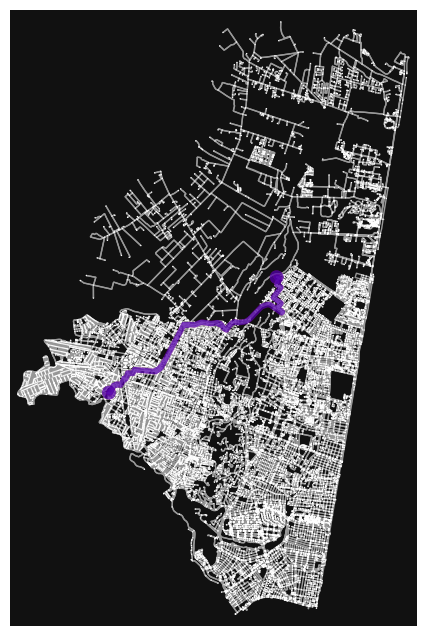

In [206]:
fig, ax = osmnx.plot_graph_routes(
    graph,
    routes=[route_astar, route_astar1],
    route_colors=["red", "blue"],
    route_linewidth=3,
    node_size=1
)

In [207]:
# Longitud de la ruta original
length_A_E = sum(get_route_edge_attributes(graph, route_astar, "length"))

# Longitud de la ruta alternativa
length_A_M = sum(get_route_edge_attributes(graph, route_astar1, "length"))

# Imprimir comparación
print(f"Longitud de la ruta A* Euclidian: {length_A_E:.6f} m")
print(f"Longitud de la ruta A* Manhattan: {length_A_M:.6f} m")
print(f"Diferencia: {length_A_M - length_A_E:.6f} m")

Longitud de la ruta A* Euclidian: 7997.481038 m
Longitud de la ruta A* Manhattan: 7997.481038 m
Diferencia: 0.000000 m


In [203]:
# Longitud de la ruta original
length_dijktras = sum(get_route_edge_attributes(graph, route, "length"))

# Longitud de la ruta alternativa
length_A = sum(get_route_edge_attributes(graph, route_astar, "length"))

# Imprimir comparación
print(f"Longitud de la ruta dijktra´s: {length_dijktras:.6f} m")
print(f"Longitud de la ruta A*: {length_A:.6f} m")
print(f"Diferencia: {length_A - length_dijktras:.6f} m")

Longitud de la ruta dijktra´s: 7997.481038 m
Longitud de la ruta A*: 7997.481038 m
Diferencia: 0.000000 m


In [212]:
print(f"Nodos Dijkstra: {len(route)}")
print(f"Nodos A*:       {len(route_astar1)}")

Nodos Dijkstra: 174
Nodos A*:       174


Great, now we have saved all the data that was used to produce the maps into a geopackage.



## Advanced reading

Here we learned how to solve a simple routing task between origin and
destination points. What about if we have hundreads or thousands of origins?
This is the case if you want to explore the travel distances to a spesific
location across the whole city, for example, when analyzing the accessibility
of jobs and services (like in the Travel Time Matrix dataset used in previous
sections). 

Check out pyrosm documentation on [working with
graphs](https://pyrosm.readthedocs.io/en/latest/graphs.html#working-with-graphs)
for more advanced examples of network analysis in python. For example,
[pandana](https://udst.github.io/pandana/) is a fast and efficient python
library for creating aggretated network analysis in no time across large
networks, and pyrosm can be used for preparing the input data for such
analysis.